In [1]:
%pip install --upgrade tensorflow
%pip install --upgrade tensorflow-probability 
%pip install --upgrade tf-keras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)

In [33]:
d = 2
def U(x):
    U_x = (x[:, 0:1] ** 2 - 1)**2 
    for i in range(1, d):
        U_x += 0.3 * (x[:, i:i+1])**2
    return U_x

In [ ]:
class CRYOModel(tf.keras.Model):
    def __init__(self):
        super(CRYOModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))
        self.dense2 = tf.keras.layers.Dense(64, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))
        self.dense3 = tf.keras.layers.Dense(64, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))
        self.output_lay = tf.keras.layers.Dense(1, activation="sigmoid")
    
    def call(self, inputs):
        return self.output_lay(self.dense3(self.dense2(self.dense1(inputs))))

@tf.function
def loss(model, samples_O, samples_A, samples_B, V, beta=5, lamb=1000, eps=1e-6):
    rho = tf.exp(-beta * V)
    Z = tf.reduce_mean(rho) * 3
    rho_tilde = 1.0/3.0
    weights = rho / (Z + eps) / rho_tilde
    
    q_A = model(samples_A)
    q_B = model(samples_B)
    
    with tf.GradientTape() as tape:
        tape.watch(samples_O)
        q_O_for_grad = model(samples_O)
    grad_q = tape.gradient(q_O_for_grad, samples_O)
    grad_norm_sq = tf.reduce_sum(tf.square(grad_q), axis=1, keepdims=True)
    loss_grad = tf.reduce_sum(grad_norm_sq * weights) / tf.reduce_sum(weights)
    
    loss_A = tf.reduce_mean(tf.square(q_A))
    loss_B = tf.reduce_mean(tf.square(q_B - 1.0))
    
    total_loss = loss_grad + lamb * (loss_A + loss_B)
    return total_loss


In [ ]:
dim = 2
num_samples = 10000
samples_A_x0 = tf.random.uniform((num_samples//4, 1), minval=-1, maxval=-0.75) 
samples_A_rest = tf.random.uniform((num_samples//4, dim-1), minval=-1, maxval=1)
samples_A = tf.concat([samples_A_x0, samples_A_rest], axis=1)
    
    
samples_B_x0 = tf.random.uniform((num_samples//4, 1), minval=0.75, maxval=1)
samples_B_rest = tf.random.uniform((num_samples//4, dim-1), minval=-1, maxval=1)
samples_B = tf.concat([samples_B_x0, samples_B_rest], axis=1)
    
samples_O_x0 = tf.random.uniform((num_samples//2, 1), minval=-0.75, maxval=0.75)
samples_O_rest = tf.random.uniform((num_samples//2, dim-1), minval=-1, maxval=1)
samples_O = tf.concat([samples_O_x0, samples_O_rest], axis=1)

def test(samples_A, samples_B, samples_O, V=U(samples_O)):
    
    model = CRYOModel()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    epochs = 1000
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            total_loss = loss(model, samples_O, samples_A, samples_B, V)
            gradients = tape.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        q_A_vals = model(samples_A)
        q_B_vals = model(samples_B)
        q_O_vals = model(samples_O)
        
        if epoch % 100 == 0:
            print("q_A mean:", tf.reduce_mean(q_A_vals).numpy())
            print("q_B mean:", tf.reduce_mean(q_B_vals).numpy())
            print("q_O range:", tf.reduce_min(q_O_vals).numpy(), tf.reduce_max(q_O_vals).numpy())
            print(f"Epoch {epoch}, Total Loss: {total_loss.numpy()}") 


test(samples_A, samples_B, samples_O)

q_A mean: 0.4258275
q_B mean: 0.5821767
q_O range: 0.4147375 0.59287804
Epoch 0, Total Loss: 418.61871337890625
q_A mean: 0.010583528
q_B mean: 0.9893943
q_O range: 0.015753264 0.98427916
Epoch 100, Total Loss: 0.34498775005340576
q_A mean: 0.007495836
q_B mean: 0.9924803
q_O range: 0.011365301 0.98859733
Epoch 200, Total Loss: 0.22496050596237183
q_A mean: 0.0057660285
q_B mean: 0.9942058
q_O range: 0.00885788 0.9910936
Epoch 300, Total Loss: 0.1763550490140915
q_A mean: 0.0047058915
q_B mean: 0.995266
q_O range: 0.007297565 0.99265355
Epoch 400, Total Loss: 0.15346650779247284
q_A mean: 0.004001339
q_B mean: 0.99597317
q_O range: 0.006248889 0.9937051
Epoch 500, Total Loss: 0.14132879674434662
q_A mean: 0.0035044865
q_B mean: 0.99647343
q_O range: 0.0055031534 0.99445474
Epoch 600, Total Loss: 0.13434264063835144
q_A mean: 0.003138689
q_B mean: 0.9968428
q_O range: 0.0049506575 0.99501115
Epoch 700, Total Loss: 0.13008764386177063
q_A mean: 0.0028607058
q_B mean: 0.997124
q_O range: 

In [147]:
test = tf.random.uniform((1000, dim), minval = -1, maxval=1)
indices = tf.argsort(test[:, 0])
sorted_data = tf.gather(test, indices)

u_pred = model(sorted_data)


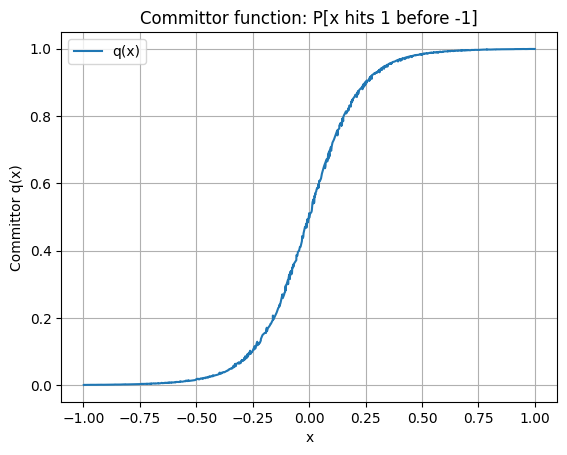

In [148]:
plt.plot(sorted_data[:, 0], u_pred, label="q(x)")
plt.xlabel("x")
plt.ylabel("Committor q(x)")
plt.title("Committor function: P[x hits 1 before -1]")
plt.grid(True)
plt.legend()
plt.show()

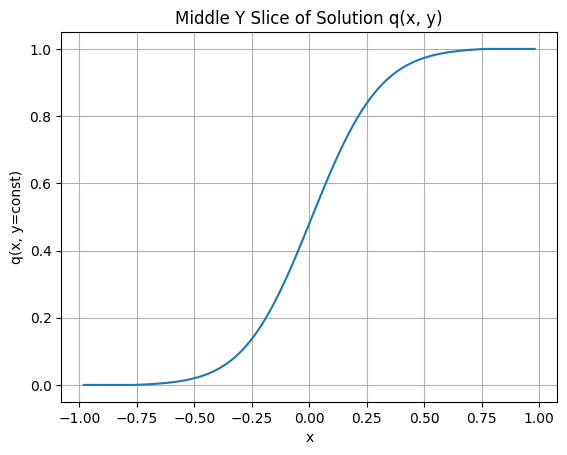

In [149]:
# Analytical FEM for double-well potential
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def dU(x):
    dU_x = 4.0 * (x[:, 0:1] ** 2 - 1) * x[:, 0:1]
    for i in range(1, dim):
        dU_x = tf.concat([dU_x, 0.6 * x[:, i:i+1]], axis=1)
    return dU_x

def fdm_2d(N, beta=5):
    h = 2.0 / (N + 1)
    N2 = N ** 2
    A = lil_matrix((N2, N2))
    C = lil_matrix((N2, N2))
    b = np.zeros(N2)

    def idx(i, j):
        return i + j * N
    
    for j in range(N):
        y = -1 + (j + 1) * h
        for i in range(N):
            x = -1 + (i + 1) * h
            p = idx(i, j)

            # Boundary conditions
            if x >= 0.75:
                b[p] = 1
                A[p, p] = 1
                continue

            if x <= -0.75:
                b[p] = 0
                A[p, p] = 1
                continue

            # Interior point
            A[p, p] = 4/(h**2 * beta)
            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                ni, nj = i + dx, j + dy
                if not (0 <= nj < N and 0 <= ni < N):
                    continue
                A[p, idx(ni, nj)] = -1/(h**2 * beta)
            
            coeffs = dU(np.array([[x, y]]))/(2*h)
            for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                ni, nj = i + dx, j + dy
                if not (0 <= nj < N and 0 <= ni < N):
                    continue
                if (dx != 0):
                    C[p, idx(ni, nj)] = coeffs[0][0]*dx
                    continue
                if (0 <= nj < N):
                    C[p, idx(ni, nj)] = coeffs[0][1]*dy
            
                    
    u = spsolve((A + C).tocsr(), b)
    return u.reshape((N, N))

# Run and visualize mid-slice
N = 100
h = 2.0 / (N + 1)
x_internal = np.linspace(-1 + h, 1 - h, N)

sol = fdm_2d(N)

plt.plot(x_internal, (sol[N // 2] + sol[N//2 + 1])/2)
plt.title("Middle Y Slice of Solution q(x, y)")
plt.xlabel("x")
plt.ylabel("q(x, y=const)")
plt.grid(True)
plt.show()

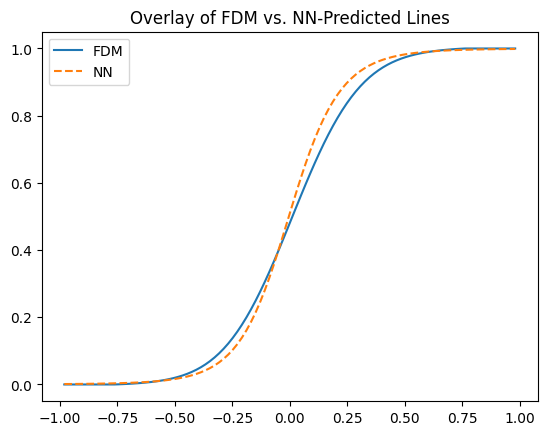

L1 (Mean) Error: 0.01862685433091073
L2 (Root Mean Square Error) Error: 0.028966841420925673
L-Infinity/L2: 2.6010964482061745


In [150]:
# Overlay between FDM (Finite Difference Method) Approximation and NN Approx
y_fdm = (sol[N // 2] + sol[N//2 + 1])/2
plt.plot(x_internal, y_fdm, label='FDM')


# NN reusing points
points = tf.concat([np.expand_dims(x_internal, axis = 1), np.expand_dims((sol[N // 2] + sol[N//2 + 1])/2, axis = 1)], axis=1)
plt.plot(x_internal, model(points), '--', label='NN')
plt.legend()
plt.title("Overlay of FDM vs. NN-Predicted Lines")
plt.show()

# Error calculation
y_nn = model(points).numpy().reshape(-1)
l1_error = np.mean(np.abs(y_nn - y_fdm))
l2_error = np.sqrt(np.mean((y_nn - y_fdm)**2))
max_error = np.max(np.abs(y_nn - y_fdm))
print(f"L1 (Mean) Error: {l1_error}")
print(f"L2 (Root Mean Square Error) Error: {l2_error}")
print(f"L-Infinity/L2: {max_error/l2_error}")

In [151]:
# Laplacian in a spherical shell
# Redefine loss function
@tf.function
def loss(model, samples_O, samples_A, samples_B, beta=5, lamb=1000, eps=1e-6):
    V = 0.0
    rho = tf.exp(-beta * V)
    Z = tf.reduce_mean(rho) * 3
    rho_tilde = 1.0/3.0
    weights = rho / (Z + eps) / rho_tilde
    
    q_A = model(samples_A)
    q_B = model(samples_B)
    
    with tf.GradientTape() as tape:
        tape.watch(samples_O)
        q_O_for_grad = model(samples_O)
    grad_q = tape.gradient(q_O_for_grad, samples_O)
    grad_norm_sq = tf.reduce_sum(tf.square(grad_q), axis=1, keepdims=True)
    loss_grad = tf.reduce_sum(grad_norm_sq * weights) / tf.reduce_sum(weights)
    
    loss_A = tf.reduce_mean(tf.square(q_A))
    loss_B = tf.reduce_mean(tf.square(q_B - 1.0))
    
    total_loss = loss_grad + lamb * (loss_A + loss_B)
    return total_loss

In [152]:
def convert_to_cart(r, theta):
    return tf.concat([r*tf.cos(theta), r*tf.sin(theta)], axis=1)

dim = 2
num_samples = 10000
samples_A_theta = tf.random.uniform((num_samples//4, 1), minval=0, maxval=2*np.pi) 
samples_A_r = tf.random.uniform((num_samples//4, 1), minval=0, maxval=0.25)
samples_A = convert_to_cart(samples_A_r, samples_A_theta)
    
samples_B_theta = tf.random.uniform((num_samples//4, 1), minval=0, maxval=2*np.pi) 
samples_B_r = tf.random.uniform((num_samples//4, 1), minval=0.75, maxval=1)
samples_B = convert_to_cart(samples_B_r, samples_B_theta)
    
samples_O_theta = tf.random.uniform((num_samples//2, 1), minval=0, maxval=2*np.pi) 
samples_O_r = tf.random.uniform((num_samples//2, 1), minval=0.25, maxval=0.75)
samples_O = convert_to_cart(samples_O_r, samples_O_theta)

test(samples_A, samples_B, samples_O)


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object is not callable

In [ ]:
dim = 2
n = 5
num_samples = 10000
samples_A_x0 = tf.random.uniform((num_samples//4, 1), minval=-1, maxval=-0.75)
samples_A_rest = tf.random.uniform((num_samples//4, dim-1), minval=-1, maxval=1)
samples_A = tf.concat([samples_A_x0, samples_A_rest], axis=1)

samples_B_x0 = tf.random.uniform((num_samples//4, 1), minval=0.75, maxval=1)
samples_B_rest = tf.random.uniform((num_samples//4, dim-1), minval=-1, maxval=1)
samples_B = tf.concat([samples_B_x0, samples_B_rest], axis=1)

samples_O_x0 = tf.random.uniform((num_samples//2, 1), minval=-0.75, maxval=0.75)
samples_O_rest = tf.random.uniform((num_samples//2, dim-1), minval=-1, maxval=1)
samples_O = tf.concat([samples_O_x0, samples_O_rest], axis=1)

model = CRYOModel()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        total_loss = loss(model, samples_O, samples_A, samples_B)
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    q_A_vals = model(samples_A)
    q_B_vals = model(samples_B)
    q_O_vals = model(samples_O)

    if epoch % 100 == 0:
        print("q_A mean:", tf.reduce_mean(q_A_vals).numpy())
        print("q_B mean:", tf.reduce_mean(q_B_vals).numpy())
        print("q_O range:", tf.reduce_min(q_O_vals).numpy(), tf.reduce_max(q_O_vals).numpy())
        print(f"Epoch {epoch}, Total Loss: {total_loss.numpy()}") 

In [ ]:
# New attempt
dim = 2
n = 5
num_samples = 10000
samples_A_x0 = tf.random.uniform((num_samples//4, 1), minval=-0.75, maxval=-0.7)
samples_A_rest = tf.random.uniform((num_samples//4, dim-1))
samples_A = tf.concat([samples_A_x0, samples_A_rest], axis=1)

samples_B_x0 = tf.random.uniform((num_samples//4, 1), minval=0.7, maxval=0.7)
samples_B_rest = tf.random.uniform((num_samples//4, dim-1))
samples_B = tf.concat([samples_B_x0, samples_B_rest], axis=1)

samples_O_x0 = tf.random.uniform((num_samples//2, 1), minval=-0.7, maxval=0.7)
samples_O_rest = tf.random.uniform((num_samples//2, dim-1))
samples_O = tf.concat([samples_O_x0, samples_O_rest], axis=1)

samples = tf.concat([samples_A, samples_B, samples_O], axis=0)

def R(q):
    return q**(1.0/n)/(q**(1.0/n) + (1-q)**(1.0/n))

def dU(x):
    dU_x1 = 4.0 * (x[:, 0:1] ** 2 - 1) * x[:, 0:1]
    for i in range(1, d):
        dU_x1 = tf.concat([dU_x1,
         0.6 * x[:, i:i+1]], axis=1)
    return dU_x1

beta = 5

model = CRYOModel()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

q = [model(samples)]
r = [R(q[0])]

for k in range(1, K + 1):
    t = 0
    x_t = tf.Variable(samples)
    V_m = 0
    active = active_mask = tf.ones(shape=(samples.shape[0],), dtype=tf.bool)
    while t < Time and tf.reduce_any(active_mask):
        with tf.GradientTape() as tape:
            tape.watch(x_t)
            q = model(x_t)
            r_val = R(q) 
            r_diff = r[k - 1] - r_val
            V_m = height * tf.exp(-tf.square(r_diff) / (2 * width**2))

        dq_dx = tape.gradient(q, x_t)  
        dR_dq = (q**(1/n - 1) * (1 - q)**(1/n - 1)) * (1/n) / (q**(1/n) + (1 - q)**(1/n))**2
        dR_dx = tf.expand_dims(dR_dq, axis=1) * dq_dx

        dVm_dr = -r_diff / (width**2) * V_m 
        print(dVm_dr.shape)
        dVm_dr_flat = tf.squeeze(dVm_dr, axis=1)
        grad_Vm = dVm_dr_flat * dR_dx

        force = -dU(x_t) - grad_Vm
        print(grad_Vm.shape)

        noise = tf.sqrt(dt * T * k_B * 2) * tf.random.normal(shape=x_t.shape)
        dx = force * dt + noise

        dx = tf.where(tf.expand_dims(active_mask, axis=1), dx, tf.zeros_like(dx))
        x_t.assign_add(dx)

        in_A = is_in_region_A(x_t)
        in_B = is_in_region_B(x_t)
        active_mask = tf.logical_and(active_mask, tf.logical_not(tf.logical_or(in_A, in_B)))

        t += dt

(10000, 1)


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [10000] vs. [10000,10000,2] [Op:Mul] name: 